In [1]:
import time
import glob as glob
from zipfile import ZipFile
from bs4 import BeautifulSoup
import dateutil.parser as dparser
import datetime
import pandas as pd
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sortedcontainers import SortedSet
from statistics import mean
import operator
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline

## Set types and drop useless data

In [2]:
df = pd.read_csv('/home/shane/Documents/thesis/output/final/failures2.csv', parse_dates=['timestamp_dir'])
df['operational_pct'] = df['operational_pct'].astype('float') * 100
df['partial_pct'] = df['partial_pct'].astype('float') * 100
df['major_pct'] = df['major_pct'].astype('float') * 100
df['maint_pct'] = df['maint_pct'].astype('float') * 100
df.drop(['timestamp_site'], axis=1, inplace=True)
df.dropna(inplace=True)

## Mean aggregation by hour

In [3]:
df_grp = df.reset_index().groupby(['service','timestamp_dir'], as_index=False).agg({'operational_pct': 'mean', 'partial_pct': 'mean', 'major_pct': 'mean', 'maint_pct': 'mean'})
df_grp.describe()

,operational_pct,partial_pct,major_pct,maint_pct
count,449279.000000,449279.000000,449279.000000,449279.000000
mean,95.619856,4.279417,0.099078,0.001648
std,19.193069,19.001882,2.468380,0.310195
min,0.000000,0.000000,0.000000,0.000000
25%,100.000000,0.000000,0.000000,0.000000
50%,100.000000,0.000000,0.000000,0.000000
75%,100.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,100.000000,100.000000


In [4]:
# print(timeseries['operational_pct'].columns.tolist())
cols = ['Access (Atlassian)',
 'Airbnb',
 'Amazon',
 'Bitbucket',
 'Blogger',
 'Cloudflare',
 'Confluence',
 'Developers (Atlassian)',
 'Discord',
 'Facebook',
 'Foursquare',
 'GitHub',
 'Gmail',
 'Google Cloud',
 'Hotmail',
 'Jira Align',
 'Jira Core',
 'Jira Service Desk',
 'Jira Software',
 'LinkedIn',
 'LiveJournal',
 'Lyft',
 'Netflix',
 'Ning',
 'Opsgenie',
 'Partners (Atlassian)',
 'PayPal',
 'Pinterest',
 'Reddit',
 'Skype',
 'Slack',
 'Snapchat',
 'Spotify',
 'Statuspage',
 'Support (Atlassian)',
 'Trello',
 'Tumblr',
 'Twitter',
 'Typepad',
 'Yahoo! Mail',
 'YouTube',
 'Zynga']

In [5]:
grouped = df.sort_values('timestamp_dir').groupby('service')

In [6]:
def mttr(col, dee_eff):
    state_changes = []
    ret = []
    for name, group in dee_eff:
        time_gaps = group[group['timestamp_dir'].diff() > datetime.timedelta(days=2)].timestamp_dir.tolist()
        timestamps = group[group[col].diff() != 0].timestamp_dir.tolist()
        state_changes = []
        
        if 'partial' in col:
            state_changes = group[group[col].diff() != 0].partial_outage_count.tolist()
        elif 'major' in col:
            state_changes = group[group[col].diff() != 0].major_outage_count.tolist()
        elif 'maint' in col:
            state_changes = group[group[col].diff() != 0].maint_count.tolist()
        
        res = []
        for i in range(0, len(state_changes)):
            for j in range(i, len(state_changes)):
                if state_changes[j] < state_changes[i]:
                    there_is_a_time_gap = False
                    for tg in time_gaps:
                        if timestamps[i] < tg and timestamps[j] > tg:
                            there_is_a_time_gap = True
                    if there_is_a_time_gap == False:
                        res.append(timestamps[j] - timestamps[i])
                        break
        ret.append(pd.to_timedelta(res).mean())
    return ret

In [7]:
df_mttr = pd.DataFrame()
df_mttr['service'] = cols

col = 'partial_outage_count'
df_mttr['mttr_po'] = mttr(col, grouped)
df_mttr['mttr_po'] = round(df_mttr['mttr_po'].dt.total_seconds() / (60 * 60), 2)

col = 'major_outage_count'
df_mttr['mttr_mo'] = mttr(col, grouped)
df_mttr['mttr_mo'] = round(df_mttr['mttr_mo'].dt.total_seconds() / (60 * 60), 2)

col = 'maint_count'
df_mttr['mttr_ma'] = mttr(col, grouped)
df_mttr['mttr_ma'] = round(df_mttr['mttr_ma'].dt.total_seconds() / (60 * 60), 2)

print(df_mttr.to_latex(index=False))
df_mttr_all = df_mttr.copy()

\begin{tabular}{lrrr}
\toprule
                service &  mttr\_po &  mttr\_mo &  mttr\_ma \\
\midrule
     Access (Atlassian) &      NaN &      NaN &      NaN \\
                 Airbnb &     1.16 &     1.00 &      NaN \\
                 Amazon &    14.31 &     2.24 &      NaN \\
              Bitbucket &     3.08 &     2.75 &     2.25 \\
                Blogger &     1.00 &      NaN &      NaN \\
             Cloudflare &    40.26 &     2.30 &     2.33 \\
             Confluence &     4.67 &     7.00 &     1.00 \\
 Developers (Atlassian) &     5.00 &     2.00 &     4.00 \\
                Discord &     1.80 &      NaN &      NaN \\
               Facebook &     1.50 &      NaN &      NaN \\
             Foursquare &     1.00 &      NaN &      NaN \\
                 GitHub &     2.28 &     1.09 &      NaN \\
                  Gmail &     1.24 &      NaN &      NaN \\
           Google Cloud &     5.63 &      NaN &      NaN \\
                Hotmail &     1.86 &      NaN &      NaN 

In [8]:
df_tmp = df.drop(df[(df.source == 'downdetector') | (df.source == 'downrightnow')].index)
df_self = df_tmp.sort_values('timestamp_dir').groupby('service')
# df_self['service'].unique().tolist()
cols = ['Access (Atlassian)',
 'Bitbucket',
 'Cloudflare',
 'Confluence',
 'Developers (Atlassian)',
 'Discord',
 'Github',
 'Google Cloud',
 'Jira Align',
 'Jira Core',
 'Jira Service Desk',
 'Jira Software',
 'Opsgenie',
 'Partners (Atlassian)',
 'Slack',
 'Statuspage',
 'Support (Atlassian)',
 'Trello']

df_mttr = pd.DataFrame()
df_mttr['service'] = cols

col = 'partial_outage_count'
df_mttr['mttr_po'] = mttr(col, df_self)
df_mttr['mttr_po'] = round(df_mttr['mttr_po'].dt.total_seconds() / (60 * 60), 2)

col = 'major_outage_count'
df_mttr['mttr_mo'] = mttr(col, df_self)
df_mttr['mttr_mo'] = round(df_mttr['mttr_mo'].dt.total_seconds() / (60 * 60), 2)

col = 'maint_count'
df_mttr['mttr_ma'] = mttr(col, df_self)
df_mttr['mttr_ma'] = round(df_mttr['mttr_ma'].dt.total_seconds() / (60 * 60), 2)

df_mttr_self = df_mttr.copy()

In [9]:
df_tmp = df.drop(df[(df.source != 'downdetector') & (df.source != 'downrightnow')].index)
df_user = df_tmp.sort_values('timestamp_dir').groupby('service')
# df_user['service'].unique().tolist()
cols = ['airbnb',
'amazon',
'blogger',
'facebook',
'foursquare',
'gmail',
'hotmail',
'linkedin',
'livejournal',
'lyft',
'netflix',
'ning',
'paypal',
'pinterest',
'reddit',
'skype',
'slack',
'snapchat',
'spotify',
'tumblr',
'twitter',
'typepad',
'yahoomail',
'youtube',
'zynga']

df_mttr = pd.DataFrame()
df_mttr['service'] = cols

col = 'partial_outage_count'
df_mttr['mttr_po'] = mttr(col, df_user)
df_mttr['mttr_po'] = round(df_mttr['mttr_po'].dt.total_seconds() / (60 * 60), 2)

col = 'major_outage_count'
df_mttr['mttr_mo'] = mttr(col, df_user)
df_mttr['mttr_mo'] = round(df_mttr['mttr_mo'].dt.total_seconds() / (60 * 60), 2)

df_mttr['mttr_ma'] = np.nan

df_mttr_user = df_mttr.copy()

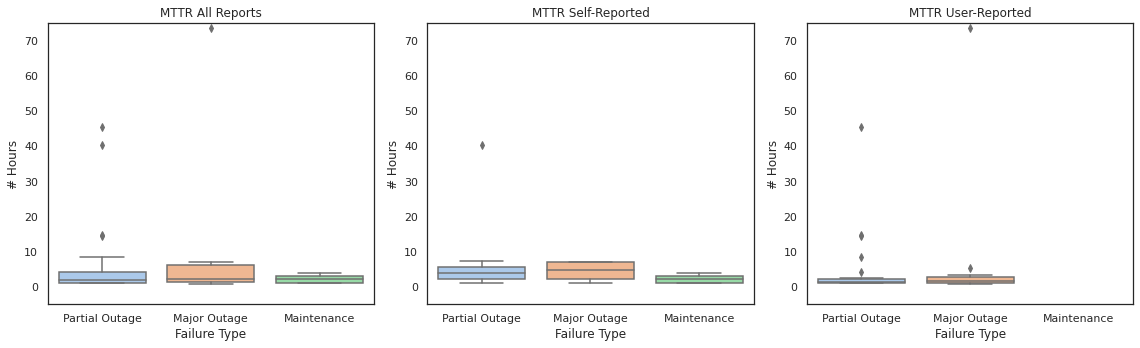

In [10]:
sns.set(rc={'figure.figsize':(16,5)})
sns.set(style='white')
fig, ax = plt.subplots(1,3)
ax0 = sns.boxplot(x='variable', y='value', palette='pastel', data=pd.melt(df_mttr_all.set_index('service')), ax=ax[0])
ax1 = sns.boxplot(x='variable', y='value', palette='pastel', data=pd.melt(df_mttr_self.set_index('service')), ax=ax[1])
ax2 = sns.boxplot(x='variable', y='value', palette='pastel', data=pd.melt(df_mttr_user.set_index('service')), ax=ax[2])
ax0.set(title='MTTR All Reports', xticklabels=['Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Failure Type', ylabel='# Hours', ylim=(-5, 75))
ax1.set(title='MTTR Self-Reported', xticklabels=['Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Failure Type', ylabel='# Hours', ylim=(-5, 75))
ax2.set(title='MTTR User-Reported', xticklabels=['Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Failure Type', ylabel='# Hours', ylim=(-5, 75))

fig.tight_layout()
plt.savefig('/home/shane/Documents/thesis/output/plots/boxes_mttr_cmp.pdf')

In [19]:
# print(round(mtbf_plot.describe(), 2).to_latex())
df_mttr_all.describe()

,mttr_po,mttr_mo,mttr_ma
count,36.000000,19.000000,7.000000
mean,5.414167,6.796842,2.225714
std,9.820797,16.285634,1.342558
min,1.000000,0.780000,1.000000
25%,1.132500,1.245000,1.000000
50%,1.830000,2.240000,2.250000
75%,4.235000,6.170000,3.165000
max,45.490000,73.360000,4.000000


In [15]:
df_mttr_self.describe()

,mttr_po,mttr_mo,mttr_ma
count,13.000000,8.000000,7.000000
mean,6.633846,4.517500,2.225714
std,10.308058,2.693329,1.342558
min,1.000000,1.090000,1.000000
25%,2.280000,2.225000,1.000000
50%,4.000000,4.875000,2.250000
75%,5.630000,7.000000,3.165000
max,40.260000,7.000000,4.000000


In [16]:
df_mttr_user.describe()

,mttr_po,mttr_mo,mttr_ma
count,24.00000,11.000000,0.0
mean,4.71875,8.462727,NaN
std,9.51735,21.564085,NaN
min,1.00000,0.820000,NaN
25%,1.03750,1.100000,NaN
50%,1.46500,1.570000,NaN
75%,2.09000,2.715000,NaN
max,45.49000,73.360000,NaN


In [12]:
# mtbf_plot2 = mtbf_plot.drop(['mtbf_ma'], axis=1)
# mtbf_plot2['mtbf_po'].corr(mtbf_plot2['mtbf_mo'])

In [13]:
# mtbf_plot[mtbf_plot['mtbf_mo'] > mtbf_plot['mtbf_mo'].mean()]